In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Reload
file_path = "./Final Results Extended.csv"
df = pd.read_csv(file_path)

# SKU와 공정 매핑
press_sku_map = {
    "Press1_Queue": "sku1",
    "Press2_Queue": "sku2",
    "Press3_Queue": "sku3",
    "Press4_Queue": "sku4",
}

warehouse_sku_map = {
    "Warehouse1_Queue": ["sku1", "sku2", "sku4"],
    "Warehouse_2_Queue": ["sku2", "sku4"],
    "Warehouse_3_Queue": ["sku2", "sku3"],
    "Warehouse_4_Queue": ["sku3", "sku4"],
}

# SKU별 병목 계산 함수
def calculate_sku_bottlenecks(df, warehouse_sku_map, press_sku_map, mode="equal", sku_weights=None):
    results = []

    for i, row in df.iterrows():
        sku_queues = {}

        # 1) Blanking (이미 SKU별 컬럼 존재)
        for s in range(1, 5):
            sku = f"sku{s}"
            q = row[f"Blanking_SKU{s}_Queue"]
            sku_queues[sku] = sku_queues.get(sku, 0) + q

        # 2) Press 단계 (매핑)
        for press_col, sku in press_sku_map.items():
            q = row[press_col]
            sku_queues[sku] = sku_queues.get(sku, 0) + q

        # 3) Warehouse 단계 (분배)
        for wh, skus in warehouse_sku_map.items():
            wh_queue = row[wh]
            if wh_queue == 0: 
                continue

            if mode == "equal":
                # 균등 분배
                for s in skus:
                    sku_queues[s] = sku_queues.get(s, 0) + wh_queue / len(skus)
            elif mode == "weighted":
                weights = sku_weights.get(wh, {s:1 for s in skus})
                total_w = sum(weights.values())
                for s in skus:
                    w = weights.get(s, 1) / total_w
                    sku_queues[s] = sku_queues.get(s, 0) + wh_queue * w

        # 4) 병목 찾기
        bottleneck_sku = max(sku_queues, key=sku_queues.get)
        bottleneck_val = sku_queues[bottleneck_sku]

        results.append({
            "Time": row["Time_Now"],
            "Bottleneck_SKU": bottleneck_sku,
            "Bottleneck_Value": bottleneck_val,
            "SKU_Queues": sku_queues
        })

    return pd.DataFrame(results)

# 실행 (균등분배 모드)
sku_bottlenecks = calculate_sku_bottlenecks(df, warehouse_sku_map, press_sku_map, mode="equal")

# 결과 확인
print(sku_bottlenecks.head())   # 앞부분 5줄만 출력

   Time Bottleneck_SKU  Bottleneck_Value  \
0  24.0           sku2        146.629252   
1  24.0           sku4        157.142875   
2  24.0           sku2        217.993846   
3  24.0           sku4        142.494984   
4  24.0           sku3        154.809579   

                                          SKU_Queues  
0  {'sku1': 89.30452866666667, 'sku2': 146.629252...  
1  {'sku1': 129.03555133333333, 'sku2': 148.28997...  
2  {'sku1': 179.13576466666666, 'sku2': 217.99384...  
3  {'sku1': 102.53398566666667, 'sku2': 122.80069...  
4  {'sku1': 101.11546166666666, 'sku2': 146.44584...  


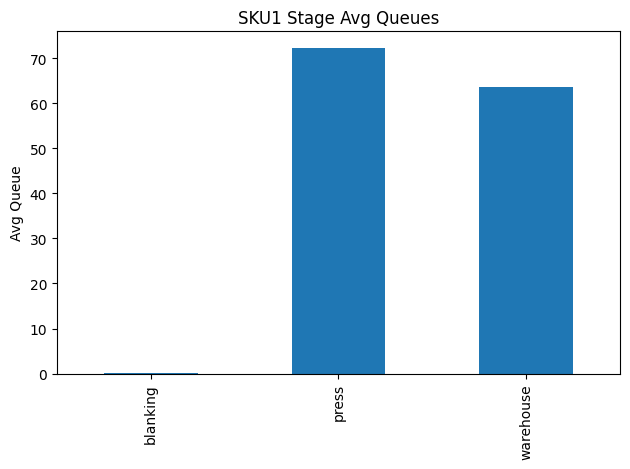

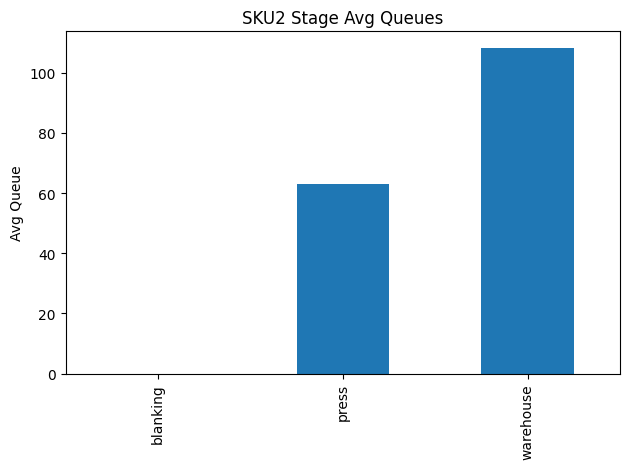

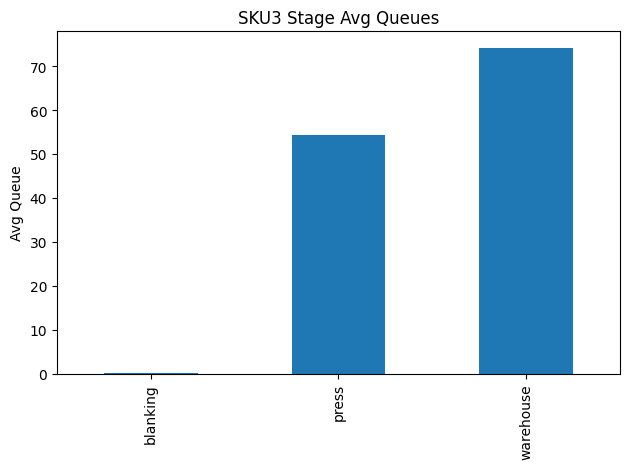

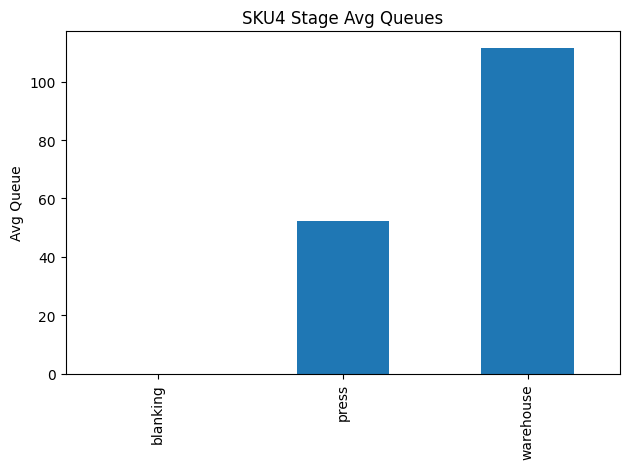

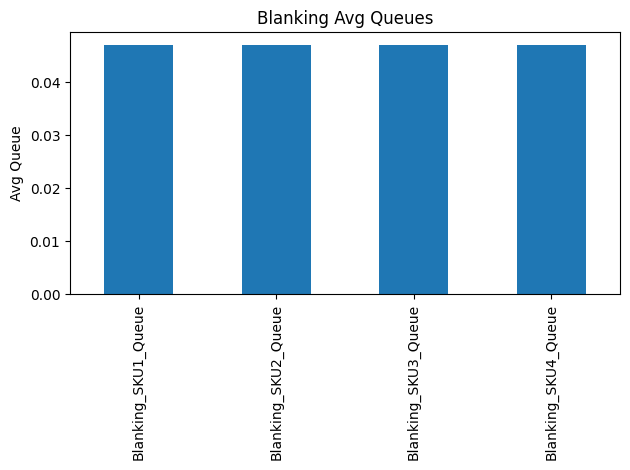

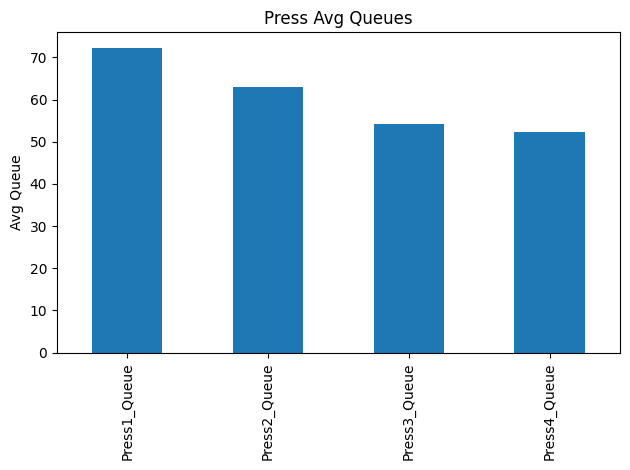

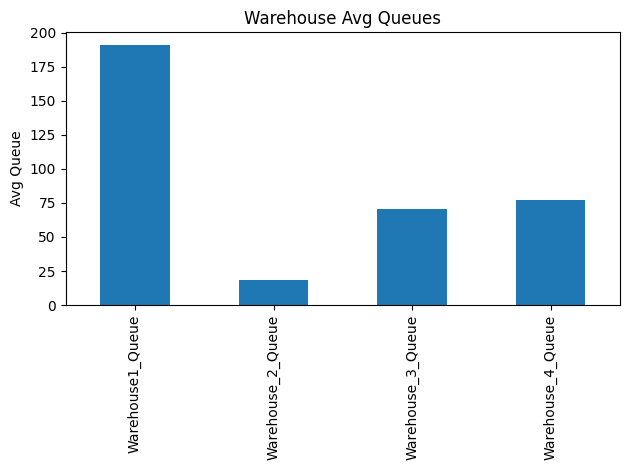

(      blanking      press   warehouse bottleneck_stage  bottleneck_value
 SKU                                                                     
 SKU1  0.047019  72.306813   63.621413            press         72.306813
 SKU2  0.047035  62.978522  108.355276        warehouse        108.355276
 SKU3  0.047063  54.254261   74.204036        warehouse         74.204036
 SKU4  0.047023  52.272512  111.647056        warehouse        111.647056,
 ('Blanking_SKU3_Queue', 'Press1_Queue', 'Warehouse1_Queue'))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Reload
file_path = "./Final Results Extended.csv"
df = pd.read_csv(file_path)

def avg(col):
    return df[col].mean()

# Warehouse → SKU 매핑
warehouse_sku_map = {
    "Warehouse1_Queue": ["SKU1", "SKU2", "SKU4"],
    "Warehouse_2_Queue": ["SKU2", "SKU4"],
    "Warehouse_3_Queue": ["SKU2", "SKU3"],
    "Warehouse_4_Queue": ["SKU3", "SKU4"],
}

# SKU paths (blanking + press)
sku_paths = {
    "SKU1": {"blanking": "Blanking_SKU1_Queue","press": "Press1_Queue"},
    "SKU2": {"blanking": "Blanking_SKU2_Queue","press": "Press2_Queue"},
    "SKU3": {"blanking": "Blanking_SKU3_Queue","press": "Press3_Queue"},
    "SKU4": {"blanking": "Blanking_SKU4_Queue","press": "Press4_Queue"},
}

# ------------------------
# Warehouse → SKU 분배 평균 계산
# ------------------------
sku_wh_means = {sku: 0 for sku in sku_paths}
for wh_col, skus in warehouse_sku_map.items():
    wh_mean = avg(wh_col)
    for s in skus:
        sku_wh_means[s] += wh_mean / len(skus)

# ------------------------
# SKU별 병목 계산
# ------------------------
sku_stage_avgs = []
for sku, path in sku_paths.items():
    row = {"SKU": sku}
    row["blanking"] = avg(path["blanking"])
    row["press"] = avg(path["press"])
    row["warehouse"] = sku_wh_means[sku]  # <- 분배 반영됨
    stages = ["blanking","press","warehouse"]
    row["bottleneck_stage"] = max(stages, key=lambda s: row[s])
    row["bottleneck_value"] = row[row["bottleneck_stage"]]
    sku_stage_avgs.append(row)

sku_stage_avgs_df = pd.DataFrame(sku_stage_avgs).set_index("SKU")

# ------------------------
# Stage group analysis
# ------------------------
cols_needed = {
    "blanking": [f"Blanking_SKU{i}_Queue" for i in range(1,5)],
    "press": [f"Press{i}_Queue" for i in range(1,5)],
    "warehouse": list(warehouse_sku_map.keys()),
}

def group_stage_summary(cols):
    means = {c: avg(c) for c in cols}
    bottleneck_col = max(means, key=means.get)
    bottleneck_val = means[bottleneck_col]
    return means, bottleneck_col, bottleneck_val

blanking_means, blanking_bneck_col, blanking_bneck_val = group_stage_summary(cols_needed["blanking"])
press_means, press_bneck_col, press_bneck_val = group_stage_summary(cols_needed["press"])
warehouse_means, wh_bneck_col, wh_bneck_val = group_stage_summary(cols_needed["warehouse"])

# ------------------------
# Plot SKU stage avg queues
# ------------------------
for sku in sku_stage_avgs_df.index:
    plt.figure()
    sku_stage_avgs_df.loc[sku, ["blanking","press","warehouse"]].plot(kind="bar", title=f"{sku} Stage Avg Queues")
    plt.ylabel("Avg Queue")
    plt.tight_layout()
    plt.show()

# ------------------------
# Plot group stage avg queues
# ------------------------
plt.figure()
pd.Series(blanking_means).plot(kind="bar", title="Blanking Avg Queues")
plt.ylabel("Avg Queue")
plt.tight_layout()
plt.show()

plt.figure()
pd.Series(press_means).plot(kind="bar", title="Press Avg Queues")
plt.ylabel("Avg Queue")
plt.tight_layout()
plt.show()

plt.figure()
pd.Series(warehouse_means).plot(kind="bar", title="Warehouse Avg Queues")
plt.ylabel("Avg Queue")
plt.tight_layout()
plt.show()

sku_stage_avgs_df, (blanking_bneck_col, press_bneck_col, wh_bneck_col)

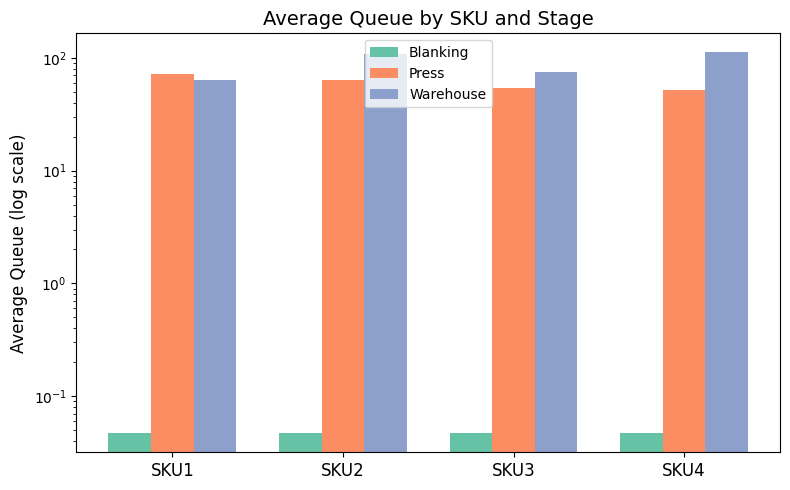

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "./Final Results Extended.csv"
df = pd.read_csv(file_path)

# Warehouse → SKU 매핑
warehouse_sku_map = {
    "Warehouse1_Queue": ["SKU1", "SKU2", "SKU4"],
    "Warehouse_2_Queue": ["SKU2", "SKU4"],
    "Warehouse_3_Queue": ["SKU2", "SKU3"],
    "Warehouse_4_Queue": ["SKU3", "SKU4"],
}

# SKU paths (blanking + press)
sku_paths = {
    "SKU1": {"blanking": "Blanking_SKU1_Queue","press": "Press1_Queue"},
    "SKU2": {"blanking": "Blanking_SKU2_Queue","press": "Press2_Queue"},
    "SKU3": {"blanking": "Blanking_SKU3_Queue","press": "Press3_Queue"},
    "SKU4": {"blanking": "Blanking_SKU4_Queue","press": "Press4_Queue"},
}

# Warehouse 분배 (벡터 방식)
sku_wh = {s: pd.Series(0, index=df.index) for s in sku_paths}
for wh_col, skus in warehouse_sku_map.items():
    for s in skus:
        sku_wh[s] += df[wh_col] / len(skus)

# SKU별 Stage 평균 정리
records = []
for sku, path in sku_paths.items():
    blanking_mean = df[path["blanking"]].mean()
    press_mean = df[path["press"]].mean()
    warehouse_mean = sku_wh[sku].mean()
    records.append({"SKU": sku, "Stage": "Blanking", "AvgQueue": blanking_mean})
    records.append({"SKU": sku, "Stage": "Press", "AvgQueue": press_mean})
    records.append({"SKU": sku, "Stage": "Warehouse", "AvgQueue": warehouse_mean})

plot_df = pd.DataFrame(records)

# ------------------------
# Plot: Grouped Bar Chart (X=SKU, Hue=Stage, Log Scale)
# ------------------------
stages = ["Blanking","Press","Warehouse"]
x = range(len(sku_paths))
bar_width = 0.25
colors = plt.cm.Set2.colors

plt.figure(figsize=(8,5))
for i, stage in enumerate(stages):
    vals = plot_df[plot_df["Stage"]==stage]["AvgQueue"].values
    plt.bar([p + i*bar_width for p in x], vals, width=bar_width, label=stage, color=colors[i])

plt.xticks([p + bar_width for p in x], sku_paths.keys(), fontsize=12)
plt.ylabel("Average Queue (log scale)", fontsize=12)
plt.yscale("log")   # 👈 로그 스케일 적용
plt.title("Average Queue by SKU and Stage", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# ================================
# 1. 데이터 로드
# ================================
file_path = "./Final Results Extended.csv"
df = pd.read_csv(file_path)

# ================================
# 2. SKU 경로 및 Cell 매핑 정의
# ================================
sku_paths = {
    "SKU1": {"blanking": "Blanking_SKU1_Queue","press": "Press1_Queue"},
    "SKU2": {"blanking": "Blanking_SKU2_Queue","press": "Press2_Queue"},
    "SKU3": {"blanking": "Blanking_SKU3_Queue","press": "Press3_Queue"},
    "SKU4": {"blanking": "Blanking_SKU4_Queue","press": "Press4_Queue"},
}

cell_sku_map = {
    "Warehouse1_Queue": ["SKU1", "SKU2", "SKU4"],  # Cell1
    "Warehouse_2_Queue": ["SKU2", "SKU4"],         # Cell2
    "Warehouse_3_Queue": ["SKU2", "SKU3"],         # Cell3
    "Warehouse_4_Queue": ["SKU3", "SKU4"],         # Cell4
}

# ================================
# 3. 병목 Stage 라벨 생성 함수
# ================================
def make_bottleneck_labels(df, sku_paths, cell_sku_map):
    labels = {}
    for sku, path in sku_paths.items():
        stage_labels = []
        for _, row in df.iterrows():
            blanking_val = row[path["blanking"]]
            press_val = row[path["press"]]
            # Cell 단계: warehouse 큐를 SKU에 분배
            cell_val = 0
            for wh_col, skus in cell_sku_map.items():
                if sku in skus:
                    cell_val += row[wh_col] / len(skus)
            # 가장 큐가 큰 Stage = 병목
            stage_dict = {"Blanking": blanking_val,
                          "Press": press_val,
                          "Cell": cell_val}
            stage_labels.append(max(stage_dict, key=stage_dict.get))
        labels[sku] = stage_labels
    return labels

labels = make_bottleneck_labels(df, sku_paths, cell_sku_map)

# ================================
# 4. Feature 선택 (X)
# ================================
feature_cols = [
    "Blanking_Queue",
    "Press1_Queue","Press2_Queue","Press3_Queue","Press4_Queue",
    "Warehouse1_Queue","Warehouse_2_Queue","Warehouse_3_Queue","Warehouse_4_Queue",
    "Forklift_Blanking_Queue","Forklift_Press_Queue","Forklift_Assembly_Queue"
]
X = df[feature_cols]

# ================================
# 5. SKU별 모델 학습
# ================================
models = {}
for sku in sku_paths.keys():
    y = labels[sku]
    # stratify 제거 (문제 해결)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\n=== {sku} ===")
    print(classification_report(y_test, y_pred))
    models[sku] = clf

# ================================
# 6. 예측 사용 예시
# ================================
sample = X.iloc[:5]  # 첫 5개 샘플
for sku, clf in models.items():
    preds = clf.predict(sample)
    print(f"{sku} 예측 병목 Stages: {preds}")


=== SKU1 ===
              precision    recall  f1-score   support

    Blanking       0.00      0.00      0.00         1
        Cell       0.98      0.97      0.98      5222
       Press       0.99      1.00      0.99     21313

    accuracy                           0.99     26536
   macro avg       0.66      0.65      0.66     26536
weighted avg       0.99      0.99      0.99     26536



D:\Project\Python_Source\Test01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Project\Python_Source\Test01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Project\Python_Source\Test01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== SKU2 ===
              precision    recall  f1-score   support

    Blanking       0.00      0.00      0.00         1
        Cell       0.99      1.00      1.00     25324
       Press       0.98      0.84      0.91      1211

    accuracy                           0.99     26536
   macro avg       0.66      0.61      0.63     26536
weighted avg       0.99      0.99      0.99     26536



D:\Project\Python_Source\Test01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Project\Python_Source\Test01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Project\Python_Source\Test01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== SKU3 ===
              precision    recall  f1-score   support

    Blanking       0.00      0.00      0.00         1
        Cell       0.99      1.00      1.00     26207
       Press       1.00      0.21      0.35       328

    accuracy                           0.99     26536
   macro avg       0.66      0.40      0.45     26536
weighted avg       0.99      0.99      0.99     26536



D:\Project\Python_Source\Test01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Project\Python_Source\Test01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Project\Python_Source\Test01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== SKU4 ===
              precision    recall  f1-score   support

    Blanking       0.00      0.00      0.00         1
        Cell       1.00      1.00      1.00     26055
       Press       0.97      0.78      0.86       480

    accuracy                           1.00     26536
   macro avg       0.66      0.59      0.62     26536
weighted avg       1.00      1.00      1.00     26536

SKU1 예측 병목 Stages: ['Press' 'Press' 'Cell' 'Press' 'Press']
SKU2 예측 병목 Stages: ['Cell' 'Cell' 'Cell' 'Cell' 'Cell']
SKU3 예측 병목 Stages: ['Cell' 'Cell' 'Cell' 'Cell' 'Cell']
SKU4 예측 병목 Stages: ['Cell' 'Cell' 'Cell' 'Cell' 'Cell']


D:\Project\Python_Source\Test01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Project\Python_Source\Test01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Project\Python_Source\Test01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


=== SKU1 ===
              precision    recall  f1-score   support

    Blanking       0.00      0.00      0.00         1
        Cell       0.98      0.97      0.98      5222
       Press       0.99      1.00      0.99     21313

    accuracy                           0.99     26536
   macro avg       0.66      0.65      0.66     26536
weighted avg       0.99      0.99      0.99     26536



D:\Project\Python_Source\Test01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Project\Python_Source\Test01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Project\Python_Source\Test01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


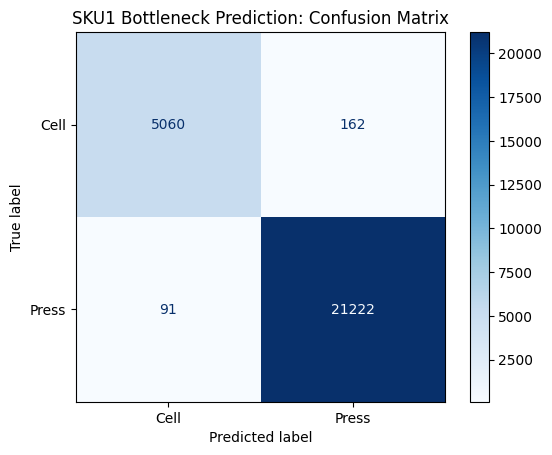

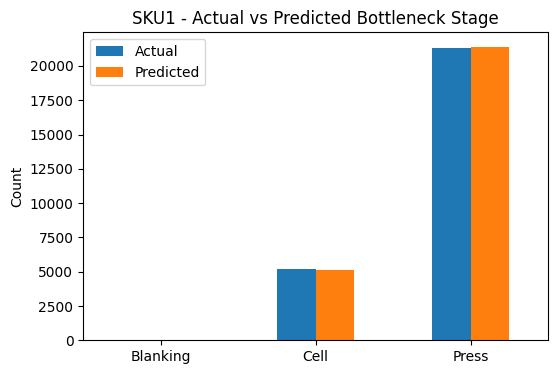

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 예시: SKU1에 대해서만 비교
sku = "SKU1"
y = labels[sku]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
clf = models[sku]

# 실제 vs 예측
y_pred = clf.predict(X_test)

# ------------------------
# 1. classification_report (텍스트 비교)
# ------------------------
print(f"=== {sku} ===")
print(classification_report(y_test, y_pred))

# ------------------------
# 2. Confusion Matrix (시각화)
# ------------------------
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap="Blues")
plt.title(f"{sku} Bottleneck Prediction: Confusion Matrix")
plt.show()

# ------------------------
# 3. 실제 vs 예측 막대 그래프 (비율 비교)
# ------------------------
true_counts = pd.Series(y_test).value_counts().sort_index()
pred_counts = pd.Series(y_pred).value_counts().sort_index()
compare_df = pd.DataFrame({"Actual": true_counts, "Predicted": pred_counts}).fillna(0)

compare_df.plot(kind="bar", figsize=(6,4))
plt.ylabel("Count")
plt.title(f"{sku} - Actual vs Predicted Bottleneck Stage")
plt.xticks(rotation=0)
plt.show()


=== SKU1 ===


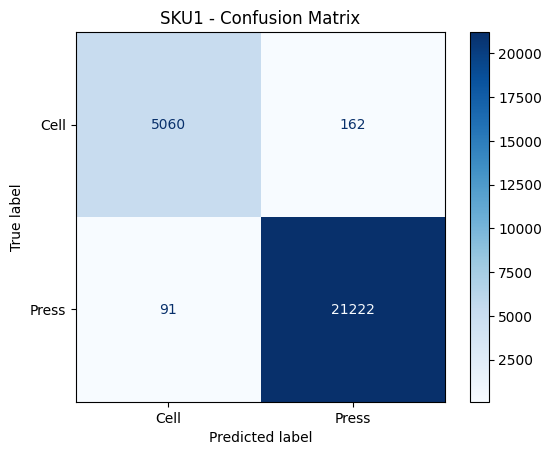

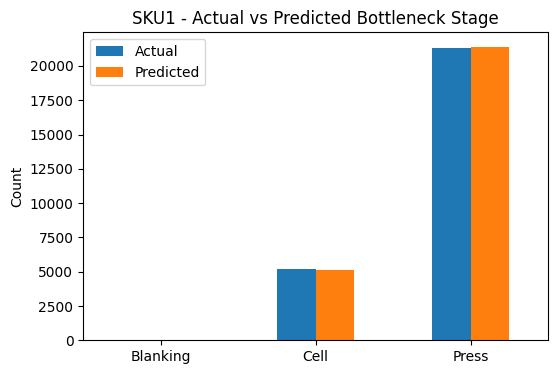


=== SKU2 ===


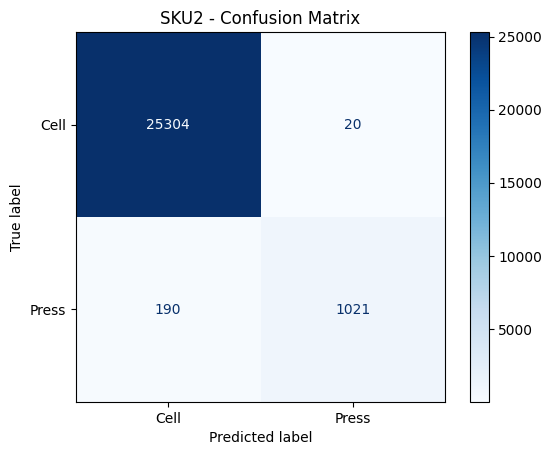

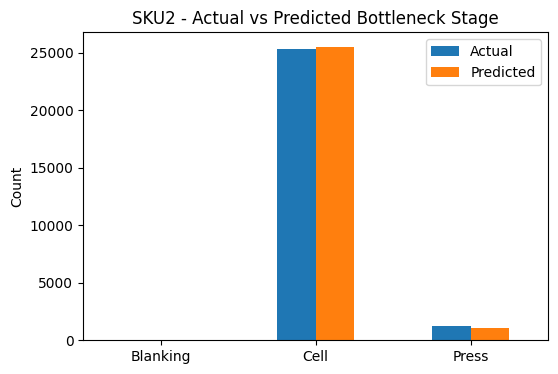


=== SKU3 ===


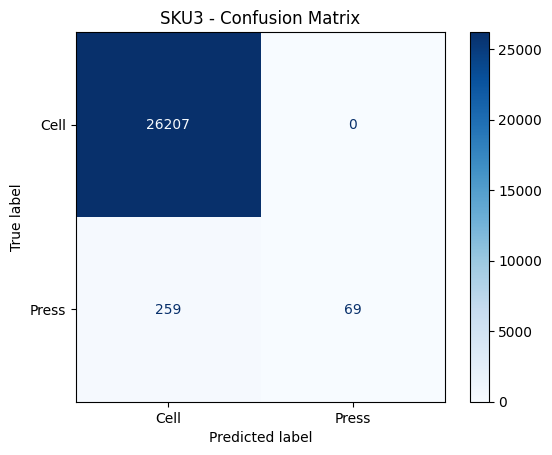

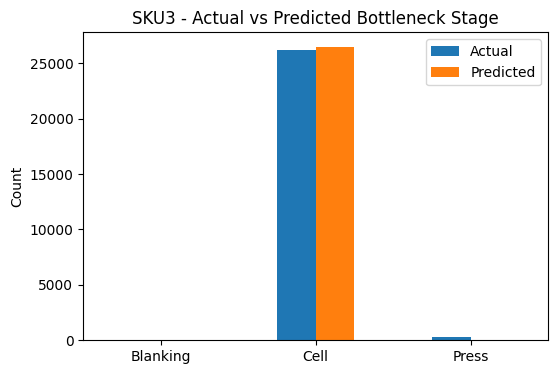


=== SKU4 ===


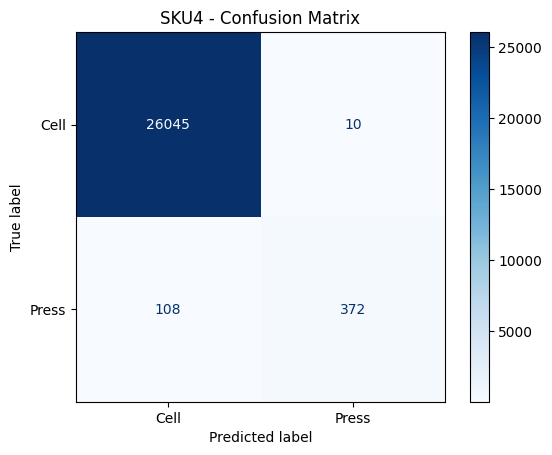

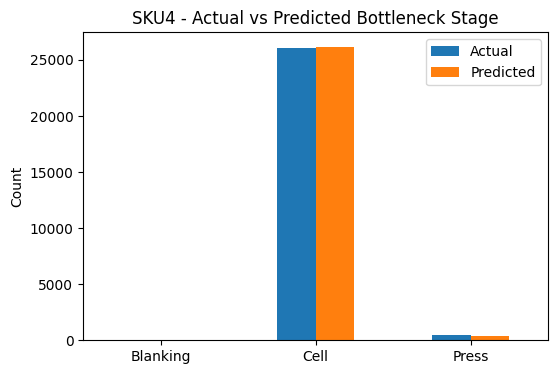

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for sku in sku_paths.keys():
    print(f"\n=== {sku} ===")
    y = labels[sku]
    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    clf = models[sku]

    # 예측
    y_pred = clf.predict(X_test)

    # ------------------------
    # 1. Confusion Matrix
    # ------------------------
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"{sku} - Confusion Matrix")
    plt.show()

    # ------------------------
    # 2. Actual vs Predicted (bar plot)
    # ------------------------
    true_counts = pd.Series(y_test).value_counts().sort_index()
    pred_counts = pd.Series(y_pred).value_counts().sort_index()
    compare_df = pd.DataFrame({"Actual": true_counts, "Predicted": pred_counts}).fillna(0)

    compare_df.plot(kind="bar", figsize=(6,4))
    plt.ylabel("Count")
    plt.title(f"{sku} - Actual vs Predicted Bottleneck Stage")
    plt.xticks(rotation=0)
    plt.show()

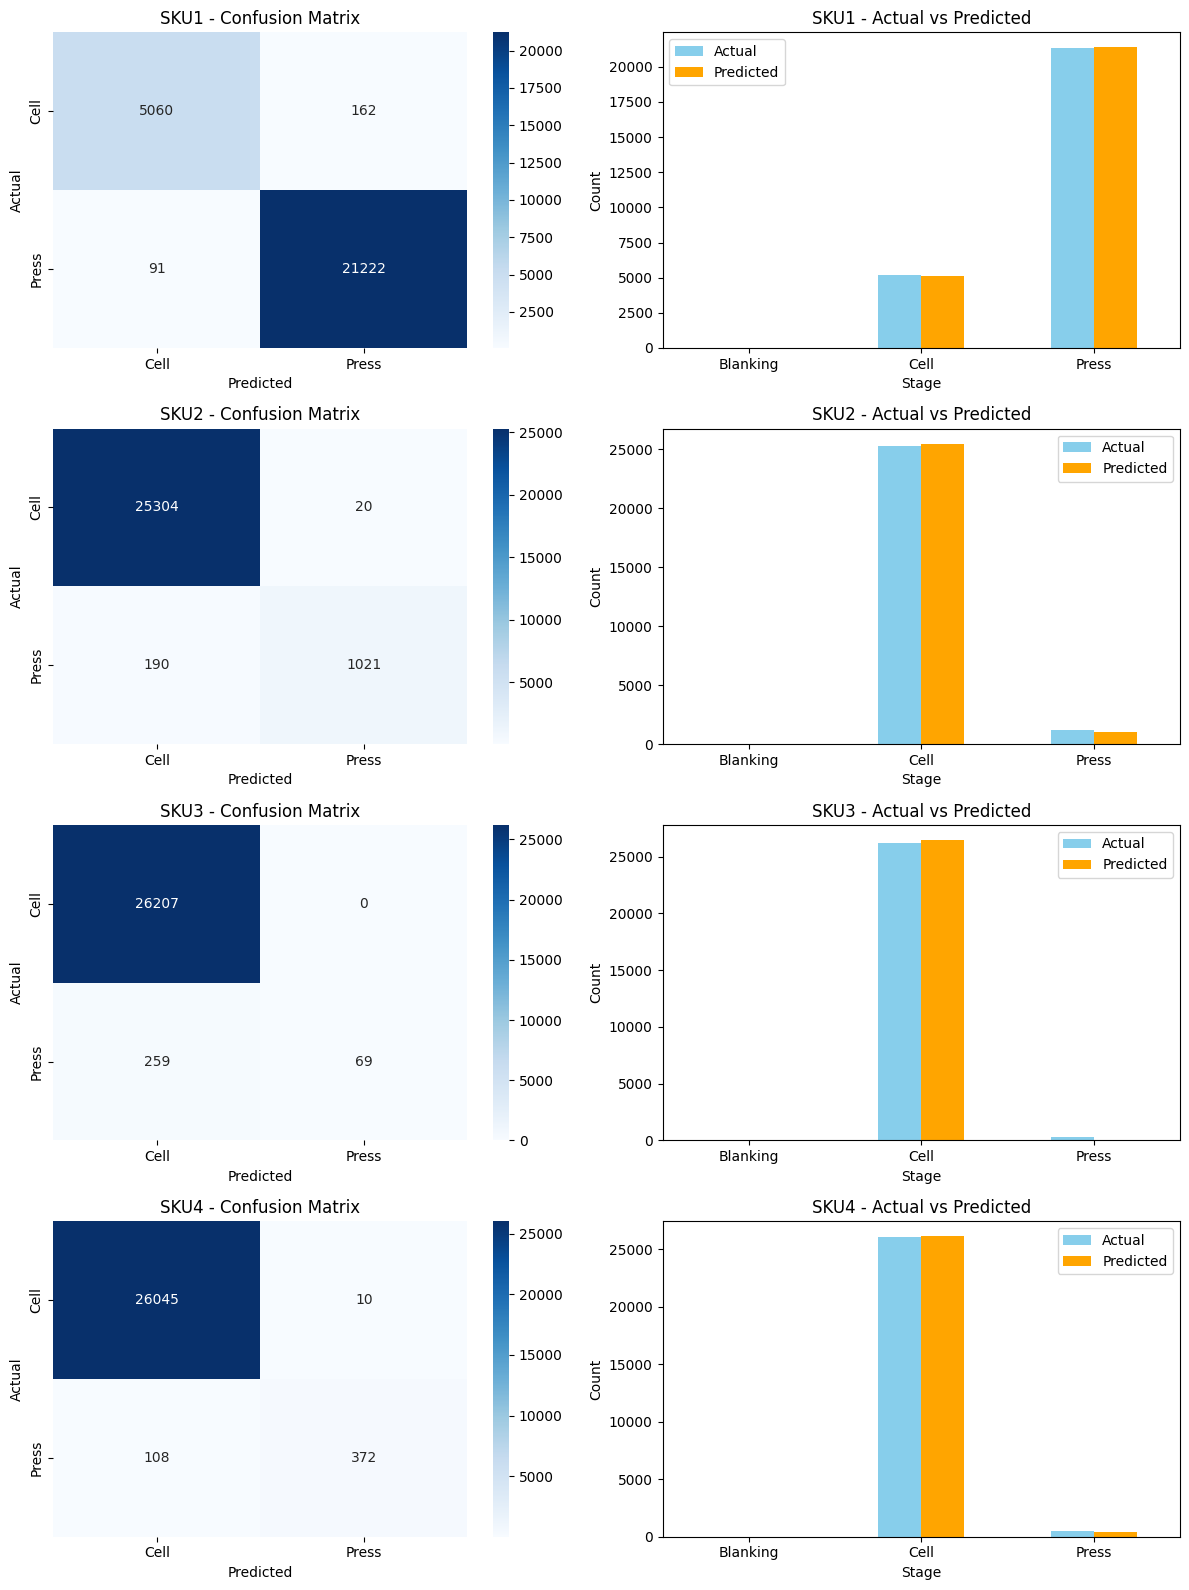

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(len(sku_paths), 2, figsize=(12, 16))

for i, sku in enumerate(sku_paths.keys()):
    y = labels[sku]
    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    clf = models[sku]
    y_pred = clf.predict(X_test)

    # ------------------------
    # Confusion Matrix
    # ------------------------
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=clf.classes_,
                yticklabels=clf.classes_,
                ax=axes[i,0])
    axes[i,0].set_title(f"{sku} - Confusion Matrix")
    axes[i,0].set_xlabel("Predicted")
    axes[i,0].set_ylabel("Actual")

    # ------------------------
    # Actual vs Predicted (bar plot)
    # ------------------------
    true_counts = pd.Series(y_test).value_counts().sort_index()
    pred_counts = pd.Series(y_pred).value_counts().sort_index()
    compare_df = pd.DataFrame({"Actual": true_counts, "Predicted": pred_counts}).fillna(0)

    compare_df.plot(kind="bar", ax=axes[i,1], color=["skyblue","orange"])
    axes[i,1].set_title(f"{sku} - Actual vs Predicted")
    axes[i,1].set_ylabel("Count")
    axes[i,1].set_xlabel("Stage")
    axes[i,1].tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.show()

C:\Users\KDT6\AppData\Local\Temp\ipykernel_24012\2331583483.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=plot_df, x="SKU", y="Count", hue="Type", palette="Set1", dodge=True, ci=None,


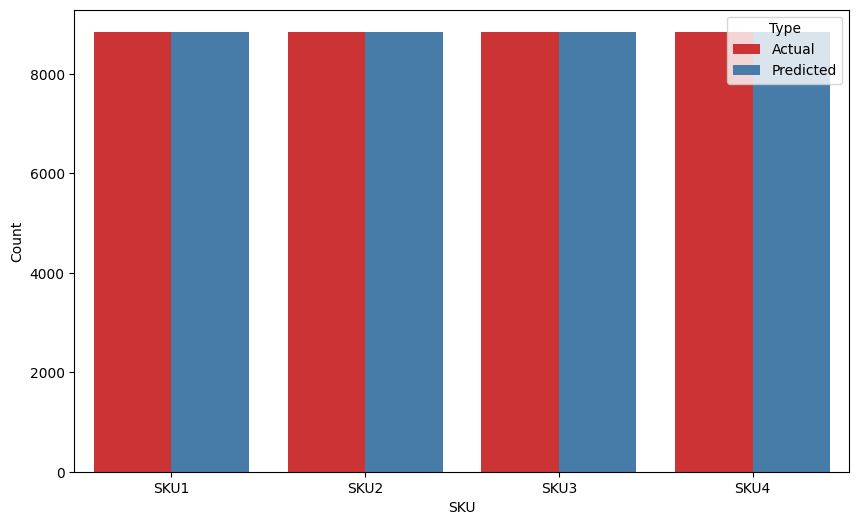

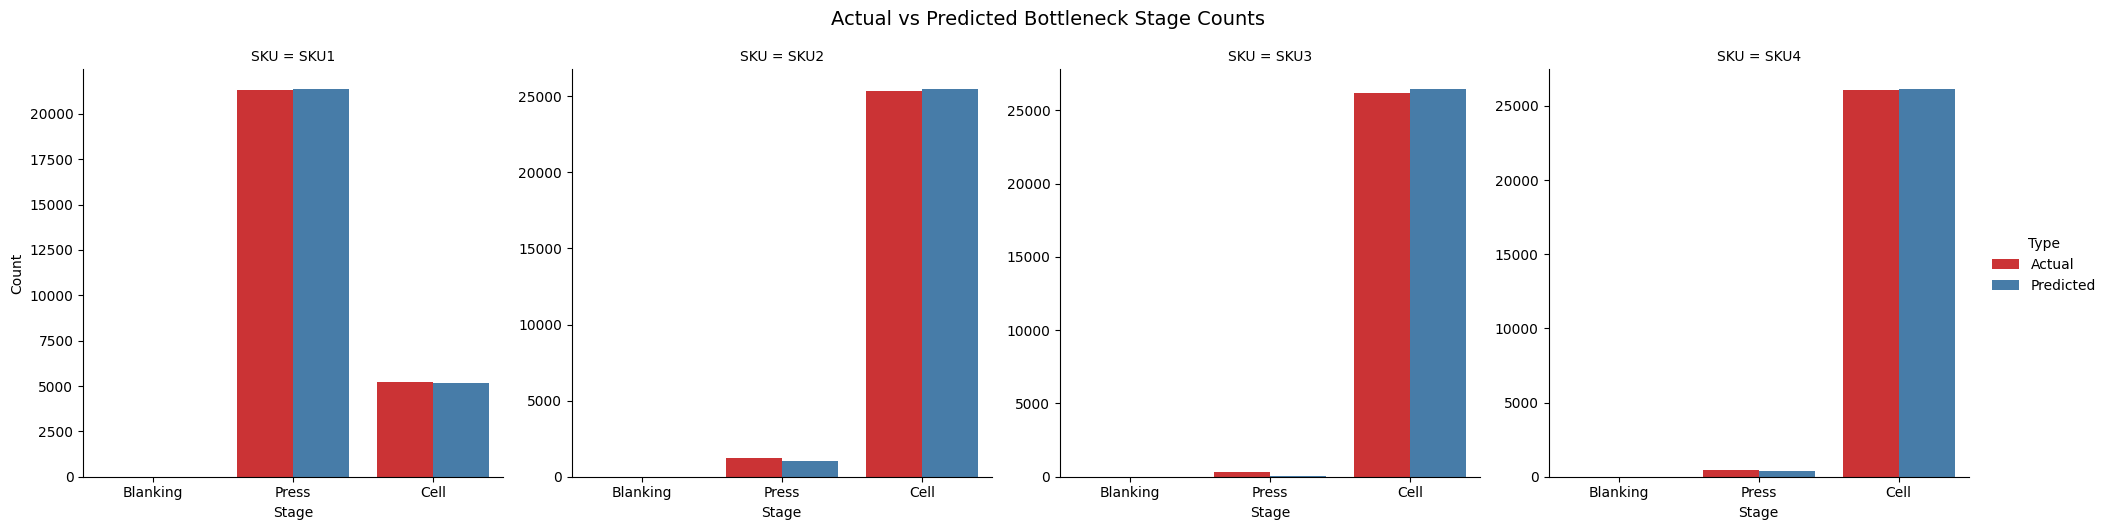

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

records = []

for sku in sku_paths.keys():
    y = labels[sku]
    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    clf = models[sku]
    y_pred = clf.predict(X_test)

    # 집계
    true_counts = pd.Series(y_test).value_counts()
    pred_counts = pd.Series(y_pred).value_counts()

    for stage in ["Blanking","Press","Cell"]:
        records.append({"SKU": sku, "Stage": stage, "Type": "Actual", "Count": true_counts.get(stage,0)})
        records.append({"SKU": sku, "Stage": stage, "Type": "Predicted", "Count": pred_counts.get(stage,0)})

plot_df = pd.DataFrame(records)

# ------------------------
# Plot (하나의 그래프)
# ------------------------
plt.figure(figsize=(10,6))
sns.barplot(data=plot_df, x="SKU", y="Count", hue="Type", palette="Set1", dodge=True, ci=None,
            hue_order=["Actual","Predicted"], errorbar=None)

# Stage별 색상 구분을 위해 facet grid-like 효과
sns.catplot(data=plot_df, x="Stage", y="Count", hue="Type", col="SKU",
            kind="bar", palette="Set1", sharey=False)

plt.suptitle("Actual vs Predicted Bottleneck Stage Counts", y=1.05, fontsize=14)
plt.show()

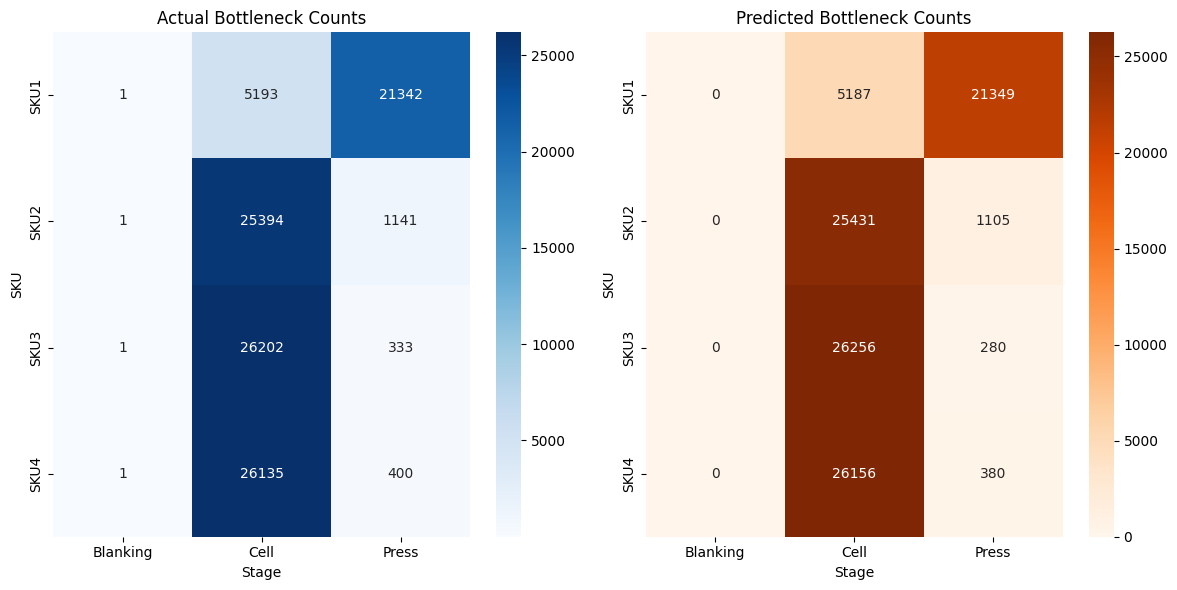

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Stage 목록
stages = ["Blanking","Press","Cell"]

# 비교 데이터 준비
records_actual = []
records_pred = []

for sku in sku_paths.keys():
    y = labels[sku]
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    clf = models[sku]
    y_pred = clf.predict(X_test)

    # stage별 "발생 횟수" 집계
    for stage in stages:
        records_actual.append({
            "SKU": sku, "Stage": stage, "Count": list(y_test).count(stage)
        })
        records_pred.append({
            "SKU": sku, "Stage": stage, "Count": list(y_pred).count(stage)
        })

df_actual = pd.DataFrame(records_actual).pivot(index="SKU", columns="Stage", values="Count")
df_pred   = pd.DataFrame(records_pred).pivot(index="SKU", columns="Stage", values="Count")

# ------------------------
# Heatmap 두 개 나란히
# ------------------------
fig, axes = plt.subplots(1, 2, figsize=(12,6))

sns.heatmap(df_actual, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Actual Bottleneck Counts")

sns.heatmap(df_pred, annot=True, fmt="d", cmap="Oranges", ax=axes[1])
axes[1].set_title("Predicted Bottleneck Counts")

plt.tight_layout()
plt.show()

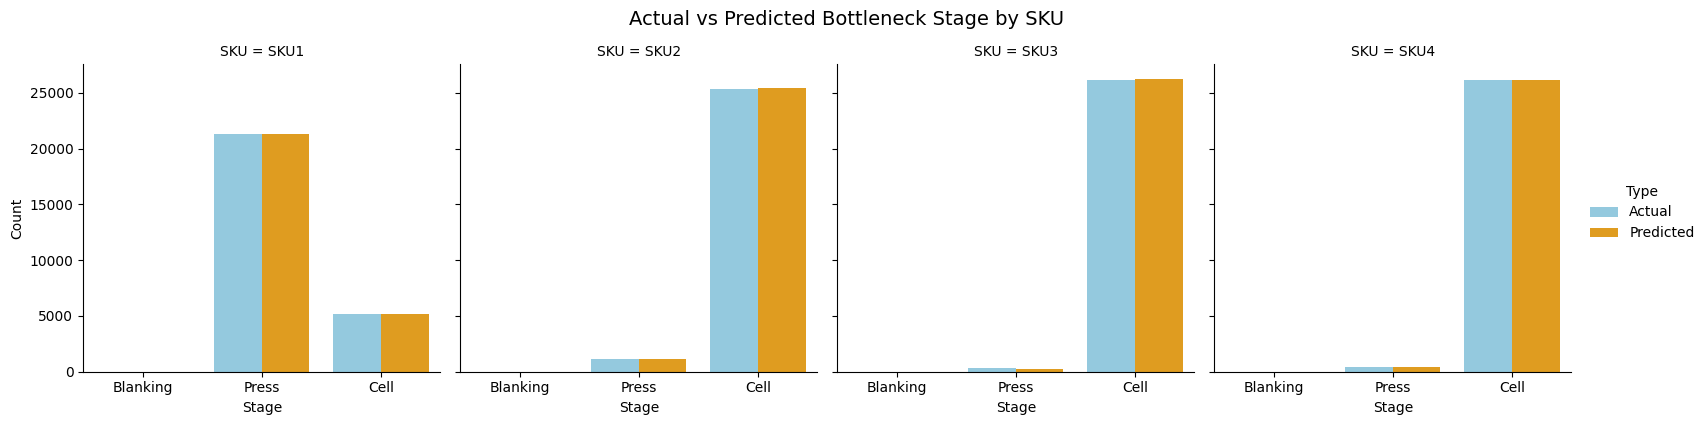

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

stages = ["Blanking","Press","Cell"]

records = []

for sku in sku_paths.keys():
    y = labels[sku]
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    clf = models[sku]
    y_pred = clf.predict(X_test)

    # stage별 발생 횟수 집계
    true_counts = pd.Series(y_test).value_counts()
    pred_counts = pd.Series(y_pred).value_counts()

    for stage in stages:
        records.append({
            "SKU": sku, "Stage": stage, "Type": "Actual", "Count": true_counts.get(stage,0)
        })
        records.append({
            "SKU": sku, "Stage": stage, "Type": "Predicted", "Count": pred_counts.get(stage,0)
        })

plot_df = pd.DataFrame(records)

# ------------------------
# Plot: Grouped Bar Chart (Stage 가로, SKU 세로, Actual vs Predicted 비교)
# ------------------------
g = sns.catplot(
    data=plot_df,
    x="Stage", y="Count",
    hue="Type", col="SKU",
    kind="bar", height=4, aspect=1,
    palette={"Actual":"skyblue", "Predicted":"orange"}
)

g.fig.suptitle("Actual vs Predicted Bottleneck Stage by SKU", y=1.05, fontsize=14)
plt.show()

In [11]:
import pandas as pd

file_path = "./Final Results Extended.csv"
df = pd.read_csv(file_path)

# ------------------------
# 1. 공정 그룹 정의
# ------------------------
stage_groups = {
    "Blanking": [f"Blanking_SKU{i}_Queue" for i in range(1,5)],
    "Press": [f"Press{i}_Queue" for i in range(1,5)],
    "Warehouse": ["Warehouse1_Queue","Warehouse_2_Queue","Warehouse_3_Queue","Warehouse_4_Queue"]
}

# ------------------------
# 2. 시점별 그룹 병목 찾기
# ------------------------
results = []

for idx, row in df.iterrows():
    row_result = {"Time": row["Time_Now"]}
    for stage, cols in stage_groups.items():
        # 그룹 내 queue 값들
        values = {col: row[col] for col in cols}
        # 병목(최대 queue) 찾기
        bottleneck_machine = max(values, key=values.get)
        bottleneck_val = values[bottleneck_machine]
        row_result[f"{stage}_Bottleneck"] = bottleneck_machine
        row_result[f"{stage}_Value"] = bottleneck_val
    results.append(row_result)

stage_bottlenecks = pd.DataFrame(results)

# ------------------------
# 3. 평균적으로 어느 공정/설비가 병목이었는지 요약
# ------------------------
summary = {}
for stage, cols in stage_groups.items():
    mean_vals = df[cols].mean()
    summary[stage] = {
        "AvgQueues": mean_vals.to_dict(),
        "BottleneckMachine": mean_vals.idxmax(),
        "BottleneckValue": mean_vals.max()
    }

print("=== 시점별 병목 결과 ===")
print(stage_bottlenecks.head())

print("\n=== 평균 병목 요약 ===")
for stage, info in summary.items():
    print(f"\n[{stage}]")
    print("평균 큐:", info["AvgQueues"])
    print("병목 설비:", info["BottleneckMachine"], "(", info["BottleneckValue"], ")")

=== 시점별 병목 결과 ===
   Time  Blanking_Bottleneck  Blanking_Value Press_Bottleneck  Press_Value  \
0  24.0  Blanking_SKU2_Queue        0.056373     Press2_Queue    65.273786   
1  24.0  Blanking_SKU2_Queue        0.052934     Press1_Queue    74.772823   
2  24.0  Blanking_SKU1_Queue        0.052210     Press2_Queue    72.901066   
3  24.0  Blanking_SKU4_Queue        0.052362     Press1_Queue    65.091192   
4  24.0  Blanking_SKU4_Queue        0.057210     Press1_Queue    65.075312   

  Warehouse_Bottleneck  Warehouse_Value  
0     Warehouse1_Queue        98.155568  
1     Warehouse1_Queue       162.632374  
2     Warehouse1_Queue       335.401556  
3     Warehouse1_Queue       112.173074  
4     Warehouse1_Queue       107.982827  

=== 평균 병목 요약 ===

[Blanking]
평균 큐: {'Blanking_SKU1_Queue': 0.04701949811571044, 'Blanking_SKU2_Queue': 0.04703476006964334, 'Blanking_SKU3_Queue': 0.04706286206246797, 'Blanking_SKU4_Queue': 0.04702333553420011}
병목 설비: Blanking_SKU3_Queue ( 0.04706286206246797

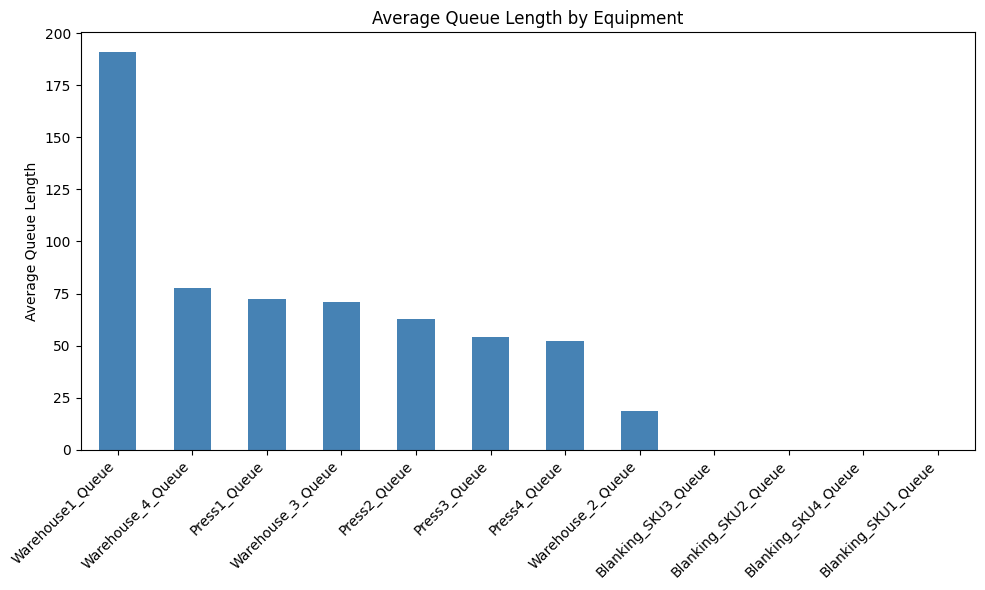

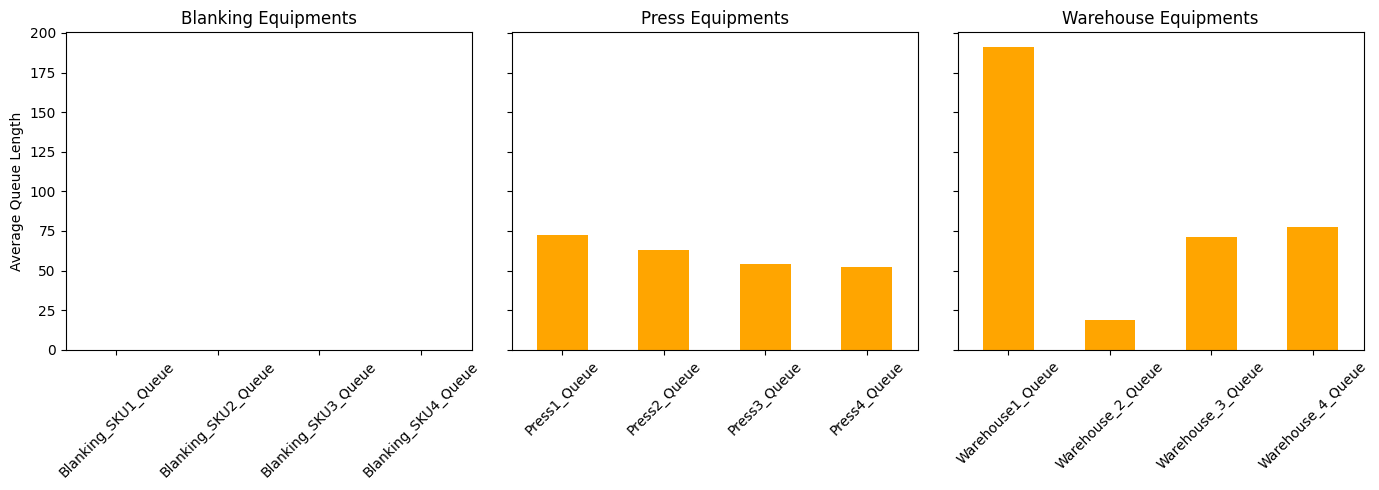

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "./Final Results Extended.csv"
df = pd.read_csv(file_path)

# ------------------------
# 1. 공정 그룹 정의
# ------------------------
stage_groups = {
    "Blanking": [f"Blanking_SKU{i}_Queue" for i in range(1,5)],
    "Press": [f"Press{i}_Queue" for i in range(1,5)],
    "Warehouse": ["Warehouse1_Queue","Warehouse_2_Queue","Warehouse_3_Queue","Warehouse_4_Queue"]
}

# ------------------------
# 2. 설비별 평균 큐 계산
# ------------------------
avg_queues = {}
for stage, cols in stage_groups.items():
    for col in cols:
        avg_queues[col] = df[col].mean()

avg_df = pd.Series(avg_queues).sort_values(ascending=False)

# ------------------------
# 3. 시각화
# ------------------------
plt.figure(figsize=(10,6))
avg_df.plot(kind="bar", color="steelblue")
plt.ylabel("Average Queue Length")
plt.title("Average Queue Length by Equipment")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ------------------------
# 4. 그룹별 시각화 (Stacked Bar)
# ------------------------
fig, axes = plt.subplots(1, 3, figsize=(14,5), sharey=True)

for i, (stage, cols) in enumerate(stage_groups.items()):
    df[cols].mean().plot(kind="bar", ax=axes[i], color="orange")
    axes[i].set_title(f"{stage} Equipments")
    axes[i].set_ylabel("Average Queue Length")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

C:\Users\KDT6\AppData\Local\Temp\ipykernel_24012\3790450424.py:24: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  bottleneck = row[cols].idxmax()
C:\Users\KDT6\AppData\Local\Temp\ipykernel_24012\3790450424.py:24: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  bottleneck = row[cols].idxmax()


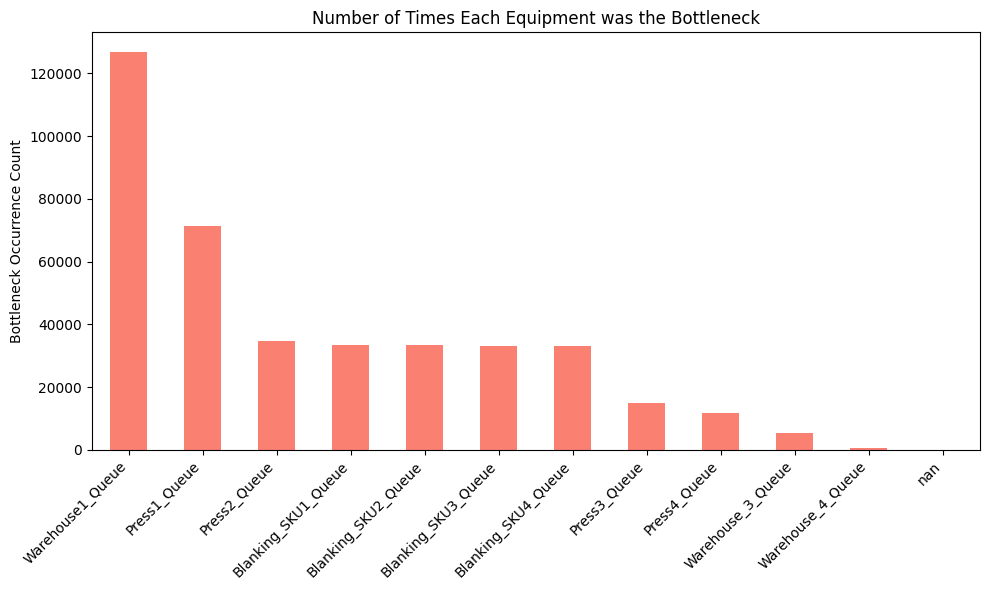

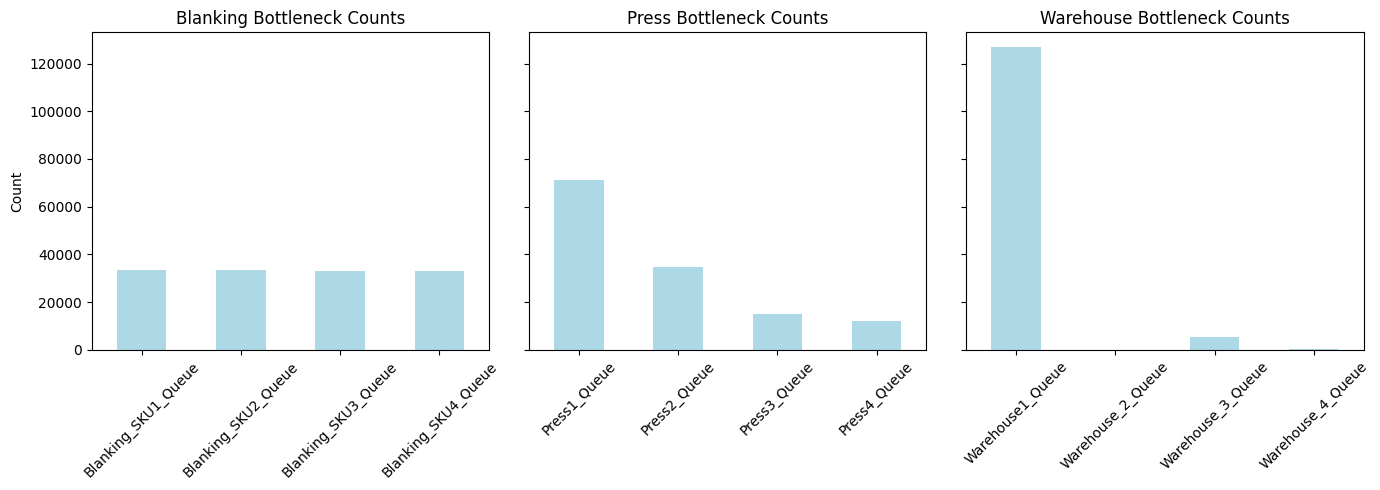

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "./Final Results Extended.csv"
df = pd.read_csv(file_path)

# ------------------------
# 1. 공정 그룹 정의
# ------------------------
stage_groups = {
    "Blanking": [f"Blanking_SKU{i}_Queue" for i in range(1,5)],
    "Press": [f"Press{i}_Queue" for i in range(1,5)],
    "Warehouse": ["Warehouse1_Queue","Warehouse_2_Queue","Warehouse_3_Queue","Warehouse_4_Queue"]
}

# ------------------------
# 2. 설비별 병목 횟수 계산
# ------------------------
bottleneck_counts = {}

for stage, cols in stage_groups.items():
    for _, row in df.iterrows():
        # 그룹 내 최대 queue 설비
        bottleneck = row[cols].idxmax()
        bottleneck_counts[bottleneck] = bottleneck_counts.get(bottleneck, 0) + 1

bn_series = pd.Series(bottleneck_counts).sort_values(ascending=False)

# ------------------------
# 3. 시각화
# ------------------------
plt.figure(figsize=(10,6))
bn_series.plot(kind="bar", color="salmon")
plt.ylabel("Bottleneck Occurrence Count")
plt.title("Number of Times Each Equipment was the Bottleneck")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ------------------------
# 4. 그룹별 병목 횟수 시각화
# ------------------------
fig, axes = plt.subplots(1, 3, figsize=(14,5), sharey=True)

for i, (stage, cols) in enumerate(stage_groups.items()):
    counts = {col: bottleneck_counts.get(col, 0) for col in cols}
    pd.Series(counts).plot(kind="bar", ax=axes[i], color="lightblue")
    axes[i].set_title(f"{stage} Bottleneck Counts")
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


=== Blanking ===
                     precision    recall  f1-score   support

Blanking_SKU1_Queue       0.99      0.99      0.99      6641
Blanking_SKU2_Queue       0.99      0.99      0.99      6568
Blanking_SKU3_Queue       0.99      0.99      0.99      6563
Blanking_SKU4_Queue       0.99      0.99      0.99      6764

           accuracy                           0.99     26536
          macro avg       0.99      0.99      0.99     26536
       weighted avg       0.99      0.99      0.99     26536



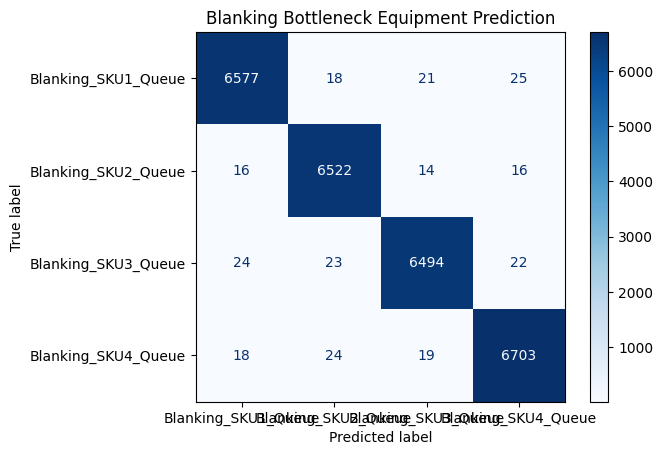


=== Press ===
              precision    recall  f1-score   support

Press1_Queue       0.99      0.99      0.99     14088
Press2_Queue       0.99      0.99      0.99      7003
Press3_Queue       0.98      0.97      0.97      2976
Press4_Queue       0.98      0.95      0.97      2469

    accuracy                           0.99     26536
   macro avg       0.98      0.97      0.98     26536
weighted avg       0.98      0.99      0.98     26536



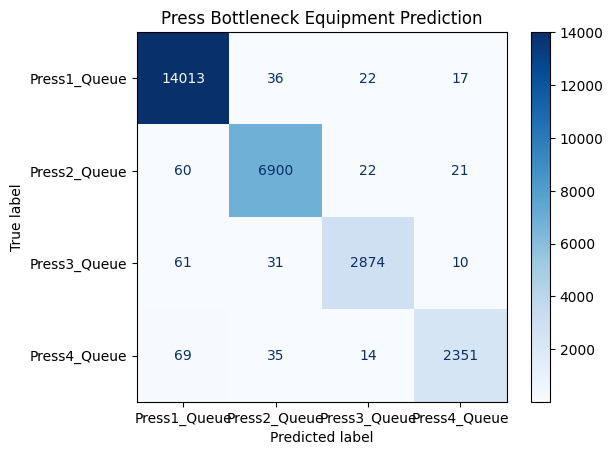


=== Warehouse ===
                   precision    recall  f1-score   support

 Warehouse1_Queue       0.99      1.00      1.00     25331
Warehouse_3_Queue       0.98      0.94      0.96      1113
Warehouse_4_Queue       1.00      0.26      0.41        92

         accuracy                           0.99     26536
        macro avg       0.99      0.73      0.79     26536
     weighted avg       0.99      0.99      0.99     26536



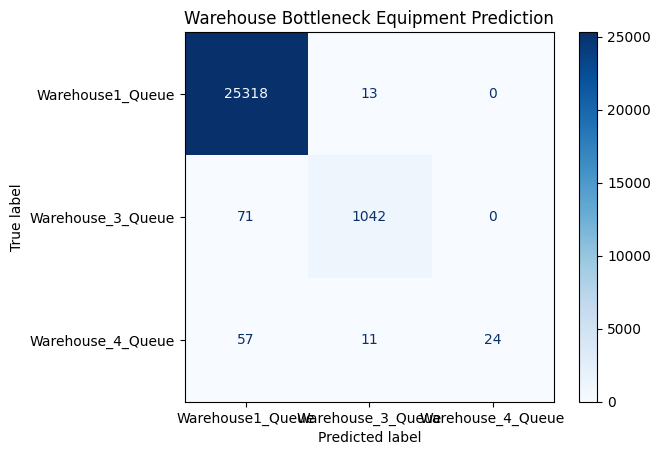

Blanking 예측: ['Blanking_SKU2_Queue' 'Blanking_SKU2_Queue' 'Blanking_SKU1_Queue'
 'Blanking_SKU4_Queue' 'Blanking_SKU4_Queue']
Press 예측: ['Press2_Queue' 'Press1_Queue' 'Press2_Queue' 'Press1_Queue'
 'Press1_Queue']
Warehouse 예측: ['Warehouse1_Queue' 'Warehouse1_Queue' 'Warehouse1_Queue'
 'Warehouse1_Queue' 'Warehouse1_Queue']


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ------------------------
# 0. 데이터 로드
# ------------------------
file_path = "./Final Results Extended.csv"
df = pd.read_csv(file_path)

# ------------------------
# 1. 공정 그룹 정의
# ------------------------
stage_groups = {
    "Blanking": [f"Blanking_SKU{i}_Queue" for i in range(1,5)],
    "Press": [f"Press{i}_Queue" for i in range(1,5)],
    "Warehouse": ["Warehouse1_Queue","Warehouse_2_Queue","Warehouse_3_Queue","Warehouse_4_Queue"]
}

# ------------------------
# 2. 병목 설비 라벨 생성
# ------------------------
labels = []
for _, row in df.iterrows():
    stage_bottlenecks = {}
    for stage, cols in stage_groups.items():
        values = row[cols].fillna(0)  # NaN은 0으로 처리
        bottleneck_machine = str(values.idxmax())  # 문자열 변환 보장
        stage_bottlenecks[stage] = bottleneck_machine
    labels.append(stage_bottlenecks)

# 라벨을 데이터프레임으로 저장
label_df = pd.DataFrame(labels)
df = pd.concat([df, label_df], axis=1)
# df에는 'Blanking','Press','Warehouse' 컬럼이 생기고 각 시점별 병목 설비 이름 저장됨

# ------------------------
# 3. Feature & Target
# ------------------------
feature_cols = sum(stage_groups.values(), []) + [
    "Forklift_Blanking_Queue","Forklift_Press_Queue","Forklift_Assembly_Queue"
]
X = df[feature_cols]

# ------------------------
# 4. 그룹별 모델 학습 & 평가
# ------------------------
models = {}
for stage in stage_groups.keys():
    y = df[stage].astype(str)  # 반드시 문자열로 변환 (float 혼입 방지)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f"\n=== {stage} ===")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"{stage} Bottleneck Equipment Prediction")
    plt.show()

    models[stage] = clf

# ------------------------
# 5. 예시 추론
# ------------------------
sample = X.iloc[:5]
for stage, clf in models.items():
    preds = clf.predict(sample)
    print(f"{stage} 예측: {preds}")